In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import glob
import matplotlib as mpl


In [ ]:
data_path = "/home/haue/repositories/Masters/data/bananas/Al/"
gam_path = "/home/haue/repositories/Masters/data/gamma/Al/withbeta/"

#outputdir = "/figure_output/"
## Load in all files from the datapath with the suffix mlio.root
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
gam_files = glob.glob(os.path.join(gam_path, "*mlio.root"))

#Files to be analyzed 
Analysis_files = gam_files

In [ ]:

# Define gamma gates and their background regions
peak_gates = {
    "580": [(565, 590), (540, 565)],
    "1247": [(1235, 1255), (1215, 1235)],
    "1460": [(1445, 1470), (1470, 1495)],
    "1634": [(1620, 1645), (1645, 1670)],
    "1980": [(1970, 2000), (2070, 2105)],
    "2060": [(2040, 2070), (2070, 2105)],
    "2130": [(2115, 2145), (2145, 2175)],
    "2320": [(2305, 2335), (2335, 2365)],
    "2614": [(2590, 2620), (2620, 2650)],
}

region_labels = ["gate", "upper_bg"]
branches = ["E", "id", "Edep"]
gprotons = {}

for gate_name, regions in peak_gates.items():
    gate_data = {label: {b: [] for b in branches} for label in region_labels}

    for region_label, (low, high) in zip(region_labels, regions):
        for gate_tag, cut_condition in [("pg1", "Eg1"), ("pg2", "Eg2")]:
            cut = f"({gate_tag}) & ({cut_condition} > {low}) & ({cut_condition} < {high})"
            for batch in uproot.iterate(Analysis_files, expressions=branches, cut=cut):
                for b in branches:
                    values = ak.flatten(batch[b])
                    gate_data[region_label][b].append(values)

    # Concatenate and clean all arrays
    for region_label in region_labels:
        for b in branches:
            all_values = np.concatenate(gate_data[region_label][b])
            gate_data[region_label][b] = all_values[~np.isnan(all_values)]

    gprotons[gate_name] = gate_data
    print(f"Gate: {gate_name} processed successfully!")


Gate: 580 processed successfully!
Gate: 1247 processed successfully!
Gate: 1460 processed successfully!
Gate: 1634 processed successfully!
Gate: 1980 processed successfully!
Gate: 2060 processed successfully!
Gate: 2130 processed successfully!
Gate: 2320 processed successfully!
Gate: 2614 processed successfully!


In [4]:
### banana Edep
Edep_ban = np.array([])
for batch in uproot.iterate(Al_files, expressions=["Edep"]):
    Edep_ban=np.append(Edep_ban, ak.flatten(batch.Edep))
Edep_ban = Edep_ban/1e3

In [5]:
####plotter function

def plot_energy_hists(
    energies_list,          # list of arrays of energies (in eV)
    reference_overlay=None, # overlay of comparison spectra
    colors=None,            # list of colors matching energies_list
    labels=None,            # list of labels matching energies_list
    bin_width=0.01,         # bin width in MeV
    scale=None,
    title="Energy Histogram",
    xlabel="Energy (MeV)",
    ylabel="default",
    xlim=(0.25, 8.5),
    fig_ax=None             # optionally pass existing (fig, ax)
):
    """
    Plot one or more energy histograms on the same figure with consistent formatting.

    Parameters:
    - energies_list: list of np.arrays, each containing energies (in eV)
    - colors: list of color strings (same length as energies_list), default black if None
    - labels: list of labels (same length as energies_list), default None (no legend)
    - bin_width: float, bin width in MeV
    - title, xlabel, ylabel: strings for the plot
    - xlim: tuple, x-axis limits
    - fig_ax: tuple (fig, ax) if you want to add to existing plot, else None to create new

    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    bins = np.arange(0, 9 + bin_width, bin_width)
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(16, 7))
    else:
        fig, ax = fig_ax
    
    if colors is None:
        colors = ['k'] * len(energies_list)
    if labels is None:
        labels = [None] * len(energies_list)
    
    for energies, color, label in zip(energies_list, colors, labels):
        ax.hist(np.array(energies) / 1e3, bins=bins, histtype='step',
                edgecolor=color, color='white', lw=1, label=label)
    
    if reference_overlay is not None:
        overlay_bins = np.arange(0, 9 + 0.01, 0.01)  # fixed 10 keV bins (0.01 MeV)
        ref_hist, ref_edges = np.histogram(np.array(reference_overlay) / 1e3, bins=overlay_bins)
        ref_hist = ref_hist.astype(float)
        ref_max = ref_hist.max()

        # Find max count from main histograms (already computed as global_max later, but for clarity compute here)
        main_max = max([np.histogram(np.array(e) / 1e3, bins=bins)[0].max() for e in energies_list])

        if ref_max > 0:
            # Scale reference histogram only if main max < 1e2
            if main_max < 1e3:
                scale_factor = 1e3 / ref_max
            else:
                scale_factor = main_max / ref_max
            ref_hist_scaled = ref_hist * scale_factor

            ref_bin_centers = (ref_edges[:-1] + ref_edges[1:]) / 2
            ax.plot(ref_bin_centers, ref_hist_scaled, color='magenta', ls='--', label='Overlay (scaled)', linewidth=1)

            
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0, 8.5, 0.25), minor=True)
    ax.set_xticks(np.arange(0, 8.5, 1))
    ax.set_xlim(*xlim)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    plt.tick_params(axis='y', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
    plt.tick_params(axis='x', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
    
    if ylabel=="default":
        ax.set_ylabel(f"Counts / {int(bin_width*1000)} keV", fontsize=16)
    else:
        ax.set_ylabel(ylabel, fontsize=16)
    global_max = 0
    for energies in energies_list:
        hist, _ = np.histogram(np.array(energies) / 1e3, bins=bins)
        current_max = hist.max()
        if current_max > global_max:
            global_max = current_max

    # Set log scale and y-limits AFTER main histograms, BEFORE overlay
    ax.set_yscale("log")
    if scale!=None:
        ymax = max(global_max, scale)*1.1
    else:
        ymax = max(global_max, 1e3) * 1.1  # Use at least 1e2, scaled a bit
    ax.set_ylim(1,ymax)
    if any(labels):
        ax.legend()
    
    return fig, ax


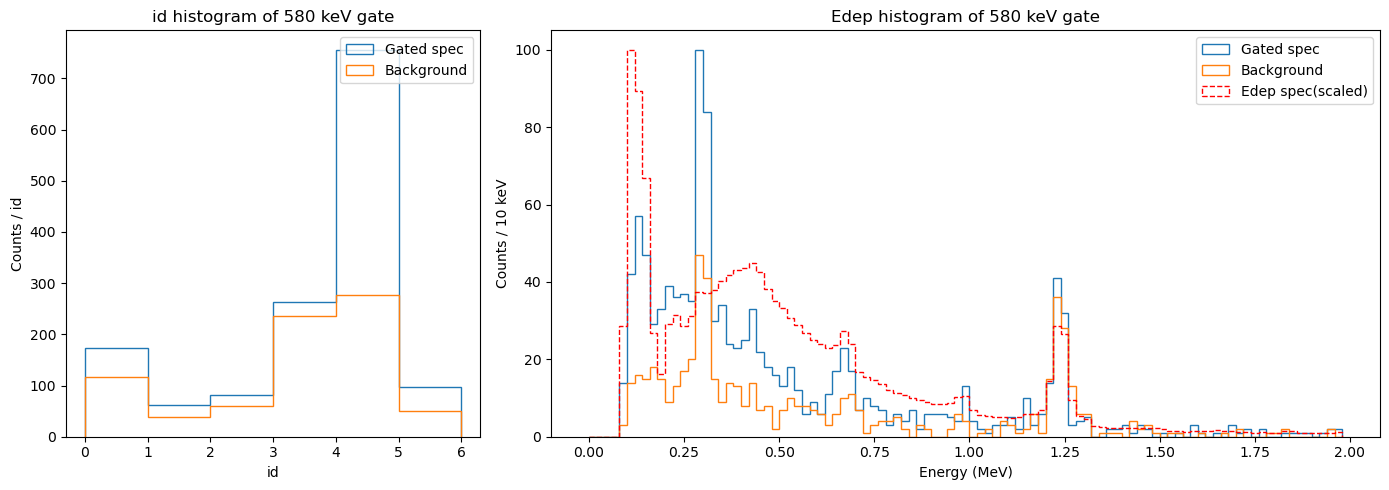

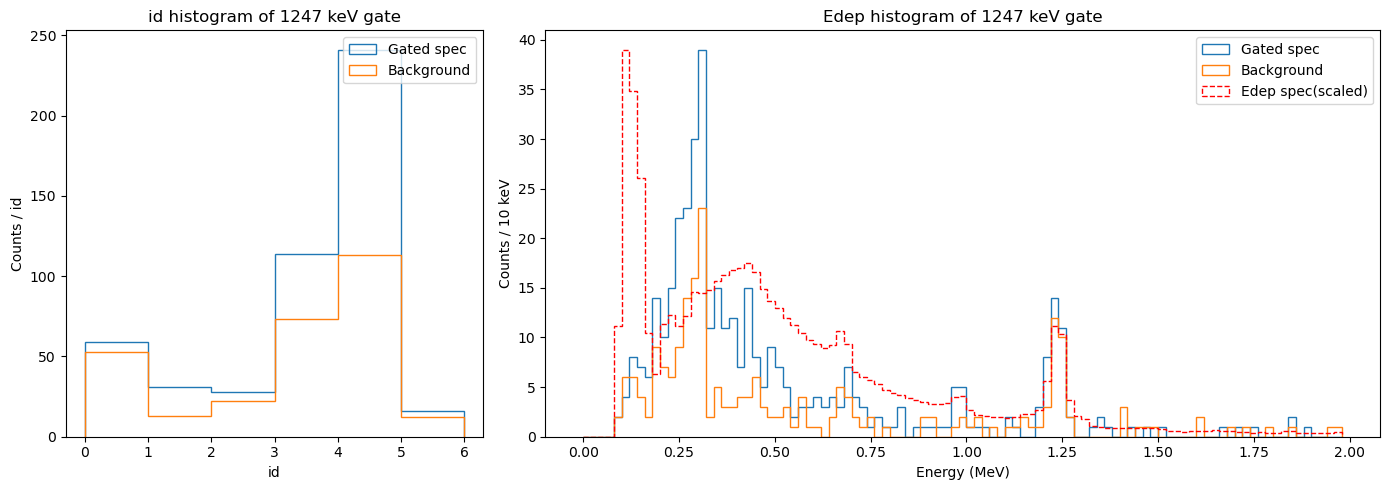

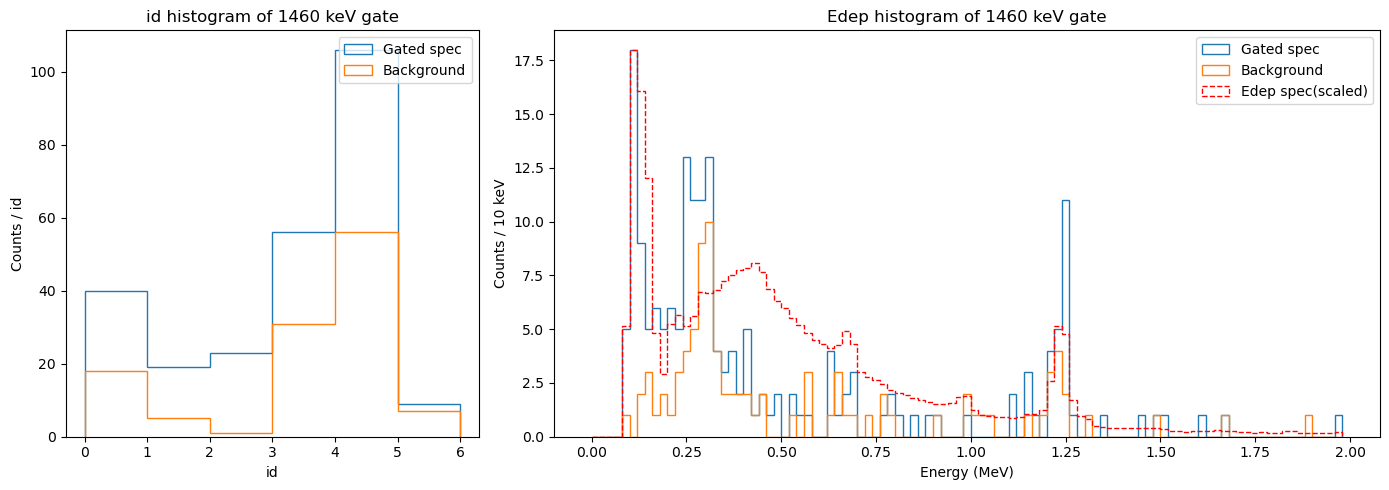

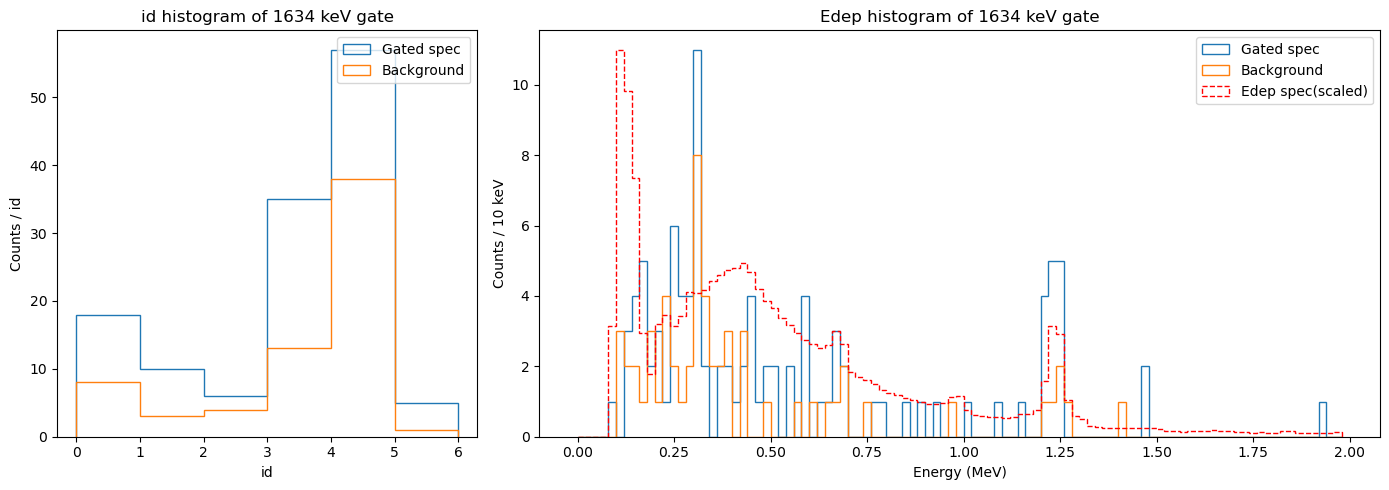

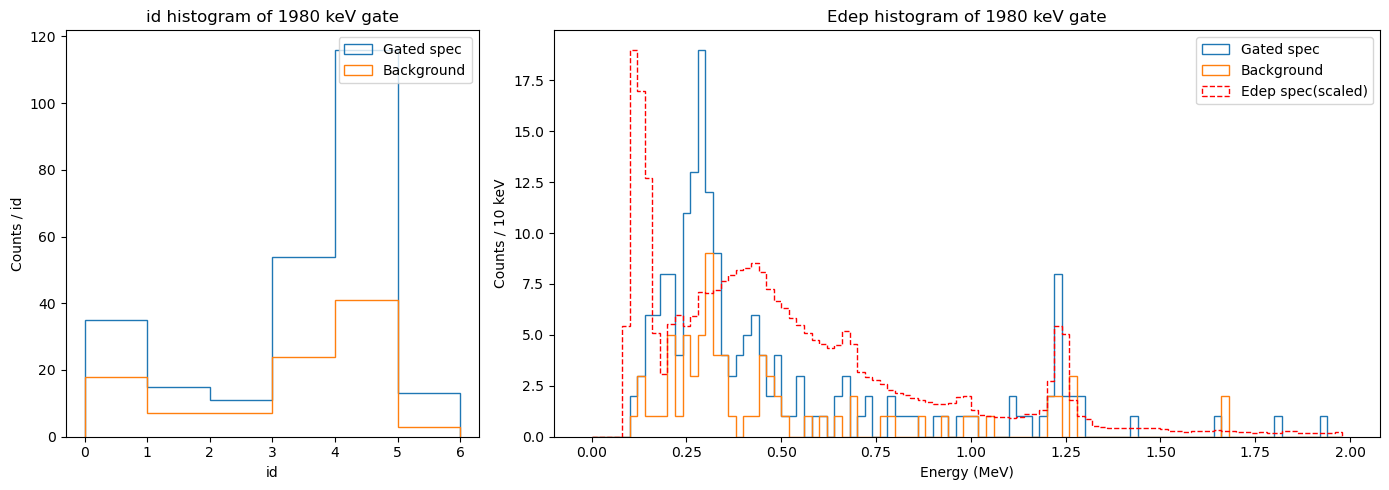

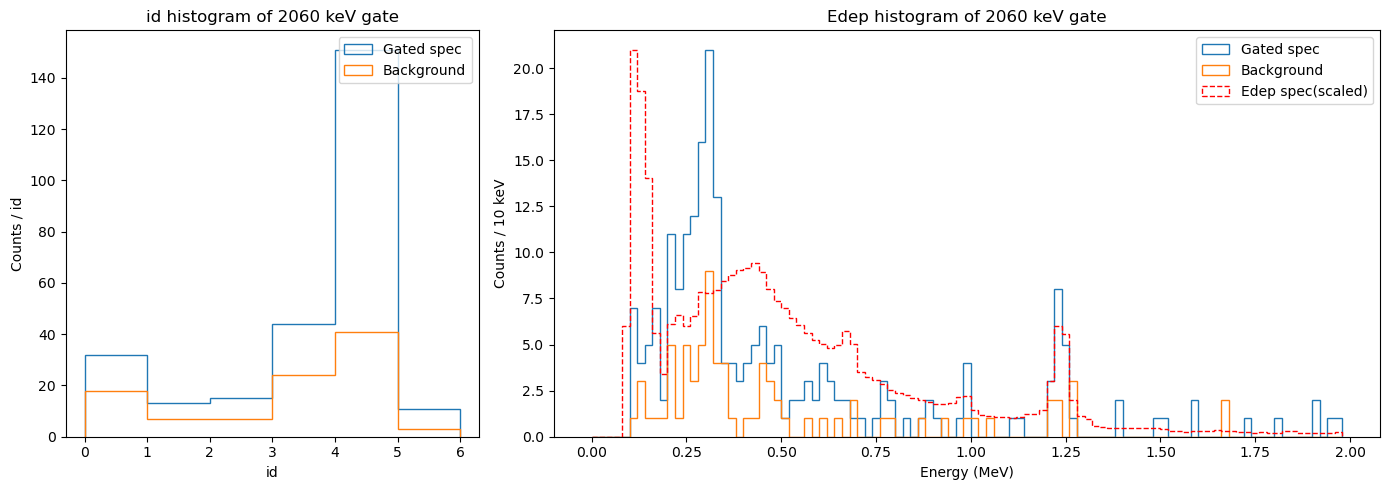

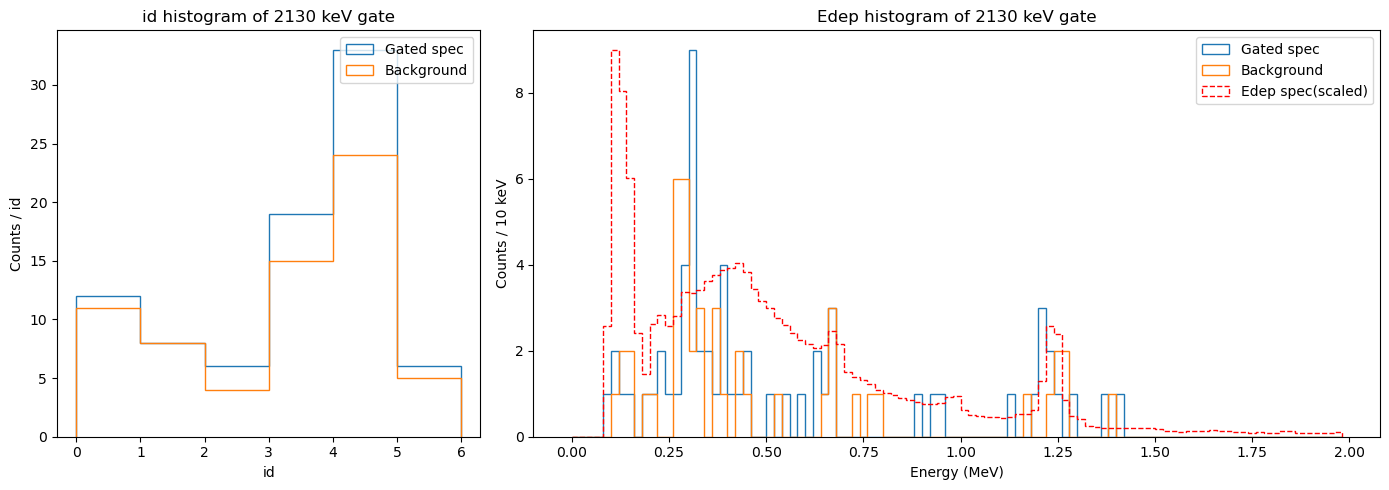

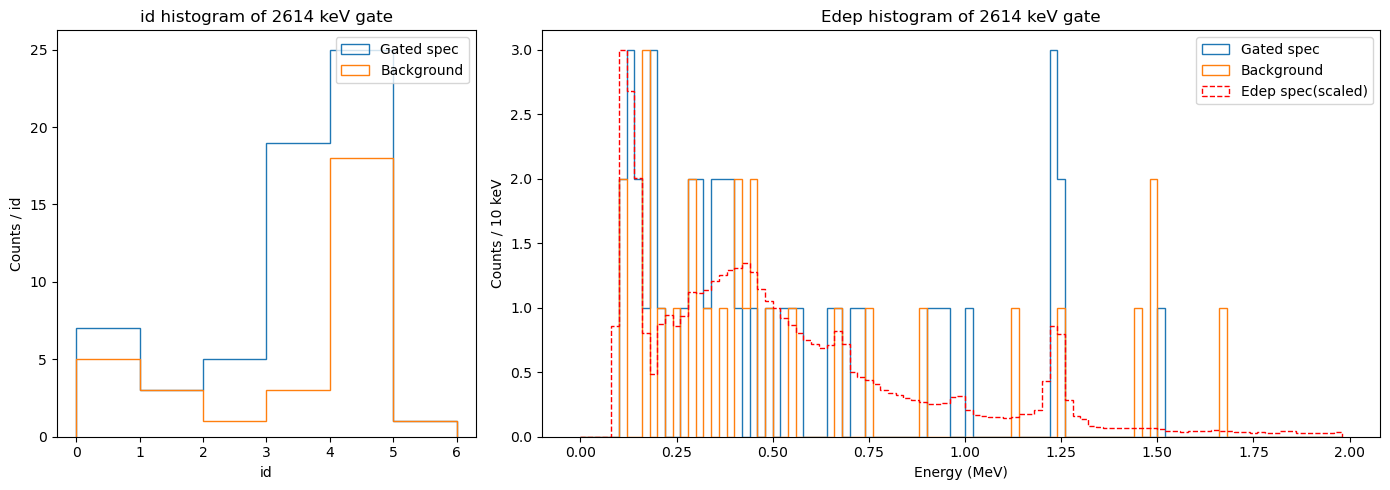

In [7]:
gates = [580, 1247, 1460, 1634, 1980, 2060, 2130, 2614]
binwidth = 0.02
bins_Edep = np.arange(0, 2, binwidth)
for g in gates:
    # Load and convert data
    ids_gate = np.array(gprotons[f"{g}"]["gate"]["id"])
    ids_bg   = np.array(gprotons[f"{g}"]["upper_bg"]["id"])
    
    Edep     = np.array(gprotons[f"{g}"]["gate"]["Edep"]) / 1e3
    Edep_bg  = np.array(gprotons[f"{g}"]["upper_bg"]["Edep"]) / 1e3
    
    # Precompute histograms for Edep to get scaling
    counts_edep, _ = np.histogram(np.asarray(Edep), bins=bins_Edep)
    counts_ban, _  = np.histogram(np.asarray(Edep_ban), bins=bins_Edep)

    max_edep = counts_edep.max()
    max_ban  = counts_ban.max()

    scale_factor = max_edep / max_ban if max_ban > 0 else 1.0

    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5),gridspec_kw={'width_ratios': [1, 2]})

    # Left plot: ID histogram
    axes[0].hist(ids_gate, bins=np.arange(0, 7, 1), histtype='step', label="Gated spec")
    axes[0].hist(ids_bg,   bins=np.arange(0, 7, 1), histtype='step', label="Background")
    axes[0].set_title(f"id histogram of {g} keV gate")
    axes[0].set_xlabel("id")
    axes[0].set_ylabel("Counts / id")
    axes[0].legend()

    # Right plot: Edep with overlay
    axes[1].hist(Edep,     bins=bins_Edep, histtype='step', label="Gated spec")
    axes[1].hist(Edep_bg,  bins=bins_Edep, histtype='step', label="Background")
    axes[1].hist(Edep_ban, bins=bins_Edep,
                 weights=np.ones_like(Edep_ban) * scale_factor,
                 histtype='step', linestyle='--', color='r',
                 label=f"Edep spec(scaled)")
    #axes[1].vlines(0.219, 0, max_edep, color='g', ls='--')
    #axes[1].vlines(0.337, 0, max_edep, color='c', ls='--')

    axes[1].set_title(f"Edep histogram of {g} keV gate")
    axes[1].set_xlabel("Energy (MeV)")
    axes[1].set_ylabel("Counts / 10 keV")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
